In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import grad, jit, vmap
from jax.scipy.ndimage import map_coordinates
import jax.lax as lax
import optax
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT
import math
import numpy as np
import equinox as eqx
import zodiax as zdx
import optax

# This was made using Connor's help - I think it's mostly a direct copy of code he already has in his repo.
phase_mask = np.load("/Users/angusrutherford/Desktop/dLuxToliman/new_diffractive_pupil.npy")

mask = dl.Optic(phase=phase_mask)

wavefront_npix = 2000 # 2000 # Wavefront number of pixels
aperture_diam = 0.125 # Diameter of aperture (m)
oversample = 1
coords = dlu.pixel_coords(wavefront_npix * oversample, aperture_diam)
secondary_diam = 0.032 # Diameter of secondary mirror (m)
spider_width = 0.002 # Spider width (m)
#psf_npixels = 256 #3600 # Number of pixels across one axis on detector
psf_npixels = 100
pixel_scale = 0.375 # Converting angle between binary source to angle on detector
primary = dlu.circle(coords, aperture_diam/2)
secondary = dlu.circle(coords, secondary_diam/2, invert=True)
angles = [0, 120, 240]
spiders = dlu.spider(coords, spider_width, angles)

aperture = dlu.combine([primary, secondary, spiders], oversample)

# Define the optical layers
layers = [("aperture", dl.layers.Optic(aperture, normalise=True)), ("phase_mask", mask)]

# Construct the optics object
# optics = dl.AngularOpticalSystem(wavefront_npix, aperture_diam, layers, psf_npixels, pixel_scale, oversample)
optics = dlT.TolimanOpticalSystem(
    wavefront_npix,
    psf_npixels,
    oversample,
    pixel_scale,
    mask=mask,
    radial_orders=[6]
    )

step    0  x= 0.39990  y= 0.39990  loss=8.212e-01
step  200  x= 0.38006  y= 0.37940  loss=8.024e-01
step  400  x= 0.36070  y= 0.35788  loss=7.810e-01
step  600  x= 0.34206  y= 0.33555  loss=7.571e-01
step  800  x= 0.32441  y= 0.31266  loss=7.311e-01
step 1000  x= 0.30805  y= 0.28941  loss=7.032e-01
step 1200  x= 0.29331  y= 0.26597  loss=6.737e-01
step 1400  x= 0.28049  y= 0.24251  loss=6.429e-01
step 1600  x= 0.26984  y= 0.21913  loss=6.113e-01
step 1800  x= 0.26151  y= 0.19593  loss=5.789e-01
step 2000  x= 0.25544  y= 0.17296  loss=5.461e-01
step 2200  x= 0.25137  y= 0.15028  loss=5.131e-01
step 2400  x= 0.24889  y= 0.12791  loss=4.801e-01
step 2600  x= 0.24750  y= 0.10589  loss=4.472e-01
step 2800  x= 0.24679  y= 0.08422  loss=4.148e-01
step 3000  x= 0.24646  y= 0.06293  loss=3.830e-01
step 3200  x= 0.24633  y= 0.04202  loss=3.519e-01
step 3400  x= 0.24631  y= 0.02150  loss=3.218e-01
step 3600  x= 0.24637  y= 0.00139  loss=2.927e-01
step 3800  x= 0.24647  y=-0.01831  loss=2.649e-01


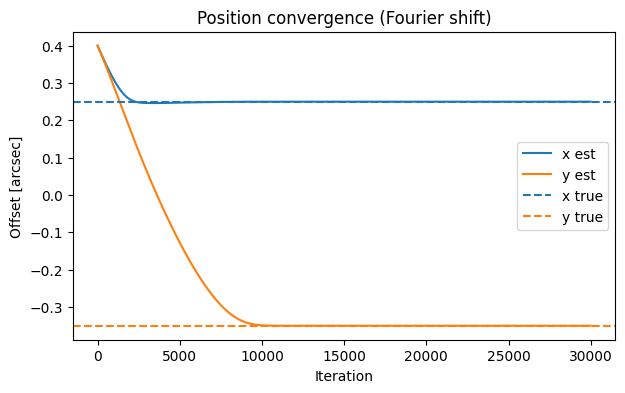

In [49]:
# -------------------------------------------------------------
# 1.  Truth and synthetic observation
# -------------------------------------------------------------
true_log_flux = 7.832
true_offsets  = jnp.array([0.25, -0.35])          # arcsec (x, y)

source_true   = dlT.AlphaCen(
    n_wavels=3, separation=10.0, position_angle=90.,
    x_position=true_offsets[0], y_position=true_offsets[1],
    log_flux=true_log_flux, contrast=3.37, bandpass=(530, 640)
)
psf_truth = dlT.Toliman(optics, source_true).model()

add_noise = False       # toggle
key_ph, key_rd = jr.split(jr.PRNGKey(0))
if add_noise:
    psf_obs = jr.poisson(key_ph, psf_truth) + 5.0*jr.normal(key_rd, psf_truth.shape)
else:
    psf_obs = psf_truth
psf_obs = psf_obs.astype(jnp.float32)
psf_obs_1 = psf_obs

# -------------------------------------------------------------
# 2.  One PSF at origin (same flux)
# -------------------------------------------------------------
source_origin = dlT.AlphaCen(
    n_wavels=3, separation=10.0, position_angle=90.,
    x_position=0.0, y_position=0.0,
    log_flux=true_log_flux, contrast=3.37, bandpass=(530, 640)
)
psf_origin = dlT.Toliman(optics, source_origin).model()

# -------------------------------------------------------------
# 3.  Fourier-domain sub-pixel shift  (fully JIT-compiled)
# -------------------------------------------------------------
pixel_scale = 0.375                              # arcsec / pixel
npix = psf_origin.shape[0]
kx = jnp.fft.fftfreq(npix)                       # (0 … 0.5 … −0.5)
ky = kx

@jax.jit
def shift_psf_fft(psf0, dx_arcsec, dy_arcsec):
    """Sub-pixel image shift via Fourier phase ramp."""
    px = dx_arcsec / pixel_scale                 # shift in pixel units
    py = dy_arcsec / pixel_scale
    # phase ramp e^{-2πi(kx·px + ky·py)}
    phase = jnp.exp(-2j * jnp.pi *
                    (jnp.outer(ky, jnp.ones(npix))*py +
                     jnp.outer(jnp.ones(npix), kx)*px))
    return jnp.real(jnp.fft.ifft2(jnp.fft.fft2(psf0) * phase))

@jax.jit
def loss_fn(xy):
    model = shift_psf_fft(psf_origin, xy[0], xy[1])
    return jnp.mean((model - psf_obs) ** 2) / jnp.mean(psf_obs**2)  # normalised MSE

grad_fn = jax.grad(loss_fn)

# -------------------------------------------------------------
# 4.  Optimise (x, y) with ADAM
# -------------------------------------------------------------
xy = jnp.array([0.4, 0.4])          # initial guess (arcsec)
opt = optax.adam(1e-4)               # smaller lr good for smooth loss
state = opt.init(xy)

hist_x, hist_y = [], []
loss_hist = []
for step in range(30000):
    g = grad_fn(xy)
    updates, state = opt.update(g, state)
    xy = optax.apply_updates(xy, updates)
    if step % 200 == 0:
        print(f"step {step:4d}  x={xy[0]: .5f}  y={xy[1]: .5f}  loss={loss_fn(xy):.3e}")
    hist_x.append(float(xy[0])); hist_y.append(float(xy[1]))
    loss_hist.append(float(loss_fn(xy)))

print("\nTrue offsets :", tuple(map(float, true_offsets)))
print("Recovered     :", tuple(map(float, xy)))

# -------------------------------------------------------------
# 5.  Plot convergence
# -------------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.plot(hist_x, label="x est"); plt.plot(hist_y, label="y est")
plt.axhline(true_offsets[0], ls="--", color='tab:blue',  label='x true')
plt.axhline(true_offsets[1], ls="--", color='tab:orange',label='y true')
plt.xlabel("Iteration"); plt.ylabel("Offset [arcsec]")
plt.title("Position convergence (Fourier shift)")
plt.legend(); plt.show()




step    0  x= 0.39990  y= 0.39990  loss=8.214e-01
step  200  x= 0.38006  y= 0.37940  loss=8.026e-01
step  400  x= 0.36070  y= 0.35788  loss=7.812e-01
step  600  x= 0.34206  y= 0.33556  loss=7.573e-01
step  800  x= 0.32441  y= 0.31266  loss=7.313e-01
step 1000  x= 0.30805  y= 0.28941  loss=7.033e-01
step 1200  x= 0.29331  y= 0.26598  loss=6.738e-01
step 1400  x= 0.28049  y= 0.24252  loss=6.431e-01
step 1600  x= 0.26985  y= 0.21914  loss=6.114e-01
step 1800  x= 0.26152  y= 0.19593  loss=5.790e-01
step 2000  x= 0.25545  y= 0.17297  loss=5.463e-01
step 2200  x= 0.25139  y= 0.15029  loss=5.132e-01
step 2400  x= 0.24891  y= 0.12792  loss=4.802e-01
step 2600  x= 0.24752  y= 0.10590  loss=4.473e-01
step 2800  x= 0.24681  y= 0.08424  loss=4.149e-01
step 3000  x= 0.24648  y= 0.06294  loss=3.830e-01
step 3200  x= 0.24635  y= 0.04204  loss=3.519e-01
step 3400  x= 0.24633  y= 0.02152  loss=3.218e-01
step 3600  x= 0.24639  y= 0.00141  loss=2.928e-01
step 3800  x= 0.24649  y=-0.01829  loss=2.649e-01


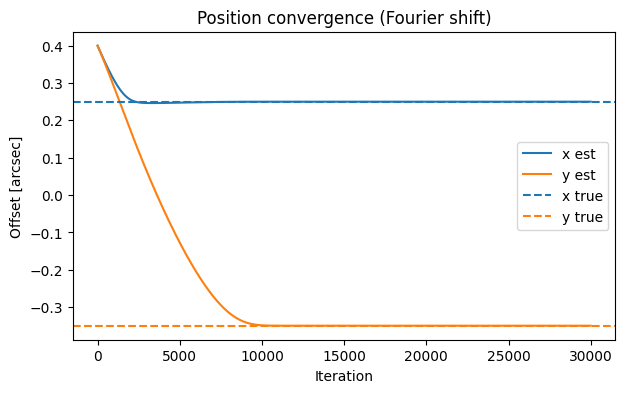

In [31]:
# -------------------------------------------------------------
# 1.  Truth and synthetic observation
# -------------------------------------------------------------
true_log_flux = 7.832
true_offsets  = jnp.array([0.25, -0.35])          # arcsec (x, y)

source_true   = dlT.AlphaCen(
    n_wavels=3, separation=10.0, position_angle=90.,
    x_position=true_offsets[0], y_position=true_offsets[1],
    log_flux=true_log_flux, contrast=3.37, bandpass=(530, 640)
)
psf_truth = dlT.Toliman(optics, source_true).model()

add_noise = True      # toggle
key_ph, key_rd = jr.split(jr.PRNGKey(0))
if add_noise:
    psf_obs = jr.poisson(key_ph, psf_truth) + 5.0*jr.normal(key_rd, psf_truth.shape)
else:
    psf_obs = psf_truth
psf_obs = psf_obs.astype(jnp.float32)
psf_obs_2 = psf_obs

# -------------------------------------------------------------
# 2.  One PSF at origin (same flux)
# -------------------------------------------------------------
source_origin = dlT.AlphaCen(
    n_wavels=3, separation=10.0, position_angle=90.,
    x_position=0.0, y_position=0.0,
    log_flux=true_log_flux, contrast=3.37, bandpass=(530, 640)
)
psf_origin = dlT.Toliman(optics, source_origin).model()

# -------------------------------------------------------------
# 3.  Fourier-domain sub-pixel shift  (fully JIT-compiled)
# -------------------------------------------------------------
pixel_scale = 0.375                              # arcsec / pixel
npix = psf_origin.shape[0]
kx = jnp.fft.fftfreq(npix)                       # (0 … 0.5 … −0.5)
ky = kx

@jax.jit
def shift_psf_fft(psf0, dx_arcsec, dy_arcsec):
    """Sub-pixel image shift via Fourier phase ramp."""
    px = dx_arcsec / pixel_scale                 # shift in pixel units
    py = dy_arcsec / pixel_scale
    # phase ramp e^{-2πi(kx·px + ky·py)}
    phase = jnp.exp(-2j * jnp.pi *
                    (jnp.outer(ky, jnp.ones(npix))*py +
                     jnp.outer(jnp.ones(npix), kx)*px))
    return jnp.real(jnp.fft.ifft2(jnp.fft.fft2(psf0) * phase))

@jax.jit
def loss_fn(xy):
    model = shift_psf_fft(psf_origin, xy[0], xy[1])
    return jnp.mean((model - psf_obs) ** 2) / jnp.mean(psf_obs**2)  # normalised MSE

grad_fn = jax.grad(loss_fn)

# -------------------------------------------------------------
# 4.  Optimise (x, y) with ADAM
# -------------------------------------------------------------
xy = jnp.array([0.4, 0.4])          # initial guess (arcsec)
opt = optax.adam(1e-4)               # smaller lr good for smooth loss
state = opt.init(xy)

hist_x_2, hist_y_2 = [], []
loss_hist_2 = []
for step in range(30000):
    g = grad_fn(xy)
    updates, state = opt.update(g, state)
    xy = optax.apply_updates(xy, updates)
    if step % 200 == 0:
        print(f"step {step:4d}  x={xy[0]: .5f}  y={xy[1]: .5f}  loss={loss_fn(xy):.3e}")
    hist_x_2.append(float(xy[0])); hist_y_2.append(float(xy[1]))
    loss_hist_2.append(float(loss_fn(xy)))

print("\nTrue offsets :", tuple(map(float, true_offsets)))
print("Recovered     :", tuple(map(float, xy)))

# -------------------------------------------------------------
# 5.  Plot convergence
# -------------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.plot(hist_x, label="x est"); plt.plot(hist_y, label="y est")
plt.axhline(true_offsets[0], ls="--", color='tab:blue',  label='x true')
plt.axhline(true_offsets[1], ls="--", color='tab:orange',label='y true')
plt.xlabel("Iteration"); plt.ylabel("Offset [arcsec]")
plt.title("Position convergence (Fourier shift)")
plt.legend(); plt.show()

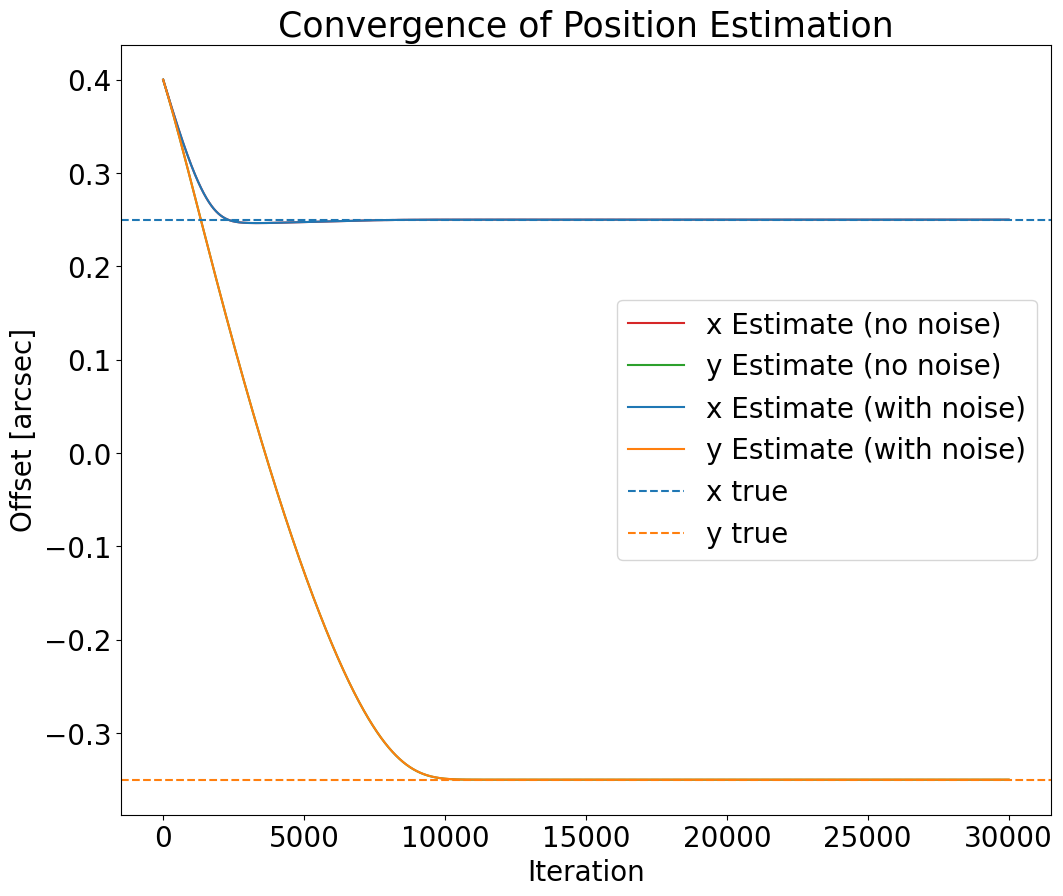

In [52]:
plt.figure(figsize=(12, 10))
#plt.plot(hist_x, label=""); plt.plot(hist_y, label="y est")
#plt.plot(hist_x, label = "x Estimate (no noise)", ls =); plt.plot(hist_y, label = "y Estimate (no noise)")
plt.plot(hist_x, label = "x Estimate (no noise)", color = "tab:red"); plt.plot(hist_y, label = "y Estimate (no noise)", color = "tab:green")
plt.plot(hist_x_2, label = "x Estimate (with noise)", color = "tab:blue"); plt.plot(hist_y_2, label = "y Estimate (with noise)", color = "tab:orange")
plt.axhline(true_offsets[0], ls="--", color='tab:blue',  label='x true')
plt.axhline(true_offsets[1], ls="--", color='tab:orange',label='y true')
plt.xlabel("Iteration", fontsize = 20); plt.ylabel("Offset [arcsec]", fontsize = 20)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.title("Convergence of Position Estimation", fontsize = 25)
plt.legend(fontsize = 20); plt.show()

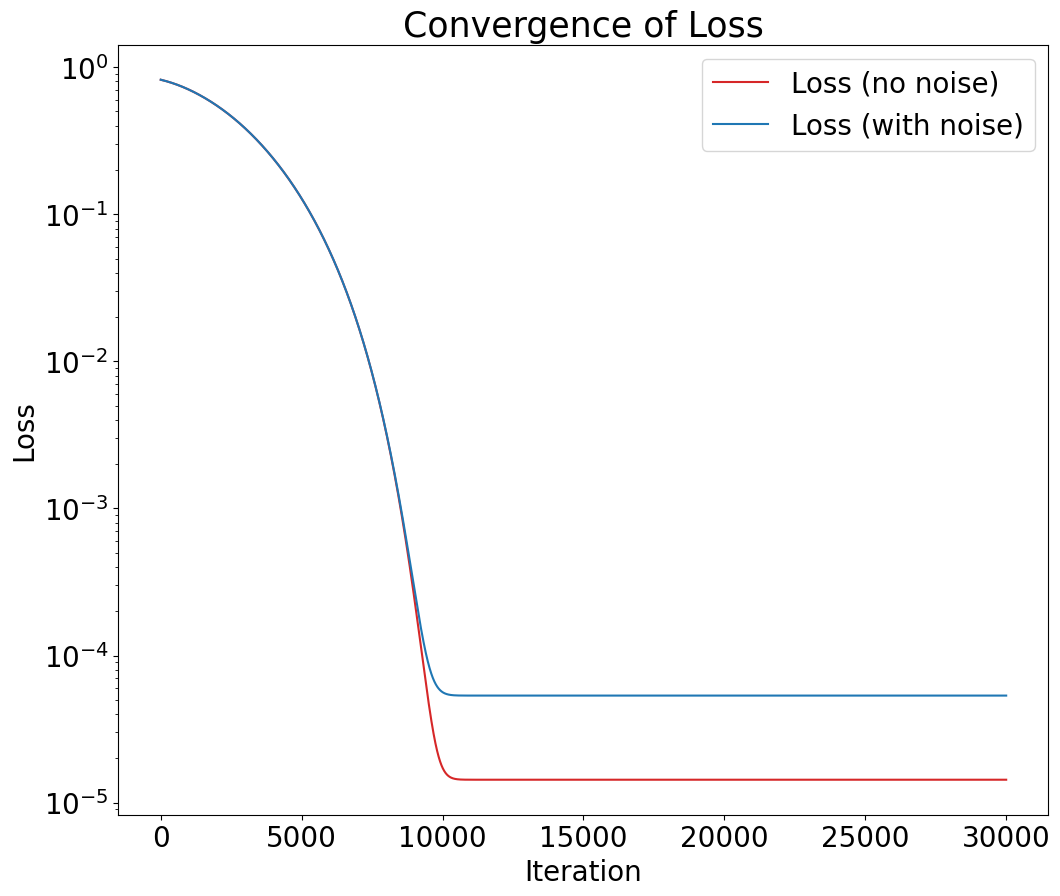

In [53]:
plt.figure(figsize=(12, 10))
plt.plot(loss_hist, label = "Loss (no noise)", color = "tab:red")
plt.plot(loss_hist_2, label = "Loss (with noise)", color = "tab:blue")
plt.xlabel("Iteration", fontsize = 20); plt.ylabel("Loss", fontsize = 20)
plt.yscale("log")
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.title("Convergence of Loss", fontsize = 25)
plt.legend(fontsize = 20); plt.show()

In [51]:
loss_hist[-1]

1.4312329767562915e-05